In [403]:
import os
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from IPython.display import clear_output
from sklearn.metrics import roc_auc_score,plot_roc_curve
from sqlalchemy import create_engine
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import datetime
from fastapi import FastAPI, HTTPException, Depends
from sqlalchemy.orm import Session
from sqlalchemy import desc,func
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import time


# New metrics

In [401]:
%matplotlib inline

In [26]:
stats = pd.read_csv('/kaggle/input/features/players_feats.csv')

# Clustering players

In [27]:
def create_players_df(stats_df):
    new_col_names = ['map_id','assists_per_round',
 'damage_per_round',
 'deaths_per_round',
 'first_kill_in_won_rounds',
 'grenade_damage_per_round',
 'headshots',
 'id',
 'kd_ratio',
 'kill_death',
 'kill_death_difference',
 'kill_round',
 'kills_per_round',
 'maps_played',
 'opening_kill_rating',
 'opening_kill_ratio',
 'rating',
 'rounds_played',
 'rounds_with_kills',
 'saved_by_teammate_per_round',
 'saved_teammates_per_round',
 'team_win_percent_after_first_kill',
 'total_deaths',
 'total_kills',
 'total_opening_deaths',
 'total_opening_kills',
                    'team_id']
    players_unique = pd.DataFrame()
    for index in stats_df.index:
        for number in range(5):
            need = [i for i in stats_df.columns if (f'p{number+1}' in i) or (i=='map_id') or (i=='team_id')]
            plr = stats_df.loc[index,need].sort_index()
            plr.index = new_col_names
            plr = plr.to_frame().T
            players_unique = pd.concat([players_unique,plr])
    players_unique = players_unique.reset_index(drop=True)
    players_unique = players_unique.drop_duplicates()
    #players_unique['KAST'] = (players_unique['kills_per_round']+players_unique['assists_per_round']+players_unique['saved_teammates_per_round'])/3
    players_unique['KAST'] = (players_unique['kills_per_round']+players_unique['assists_per_round']+players_unique['saved_teammates_per_round'])/(players_unique['kills_per_round'].mean()+players_unique['assists_per_round'].mean()+players_unique['saved_teammates_per_round'].mean())
    players_unique['KAST_ADR'] = (players_unique['kills_per_round']+players_unique['assists_per_round']+players_unique['saved_teammates_per_round']+players_unique['damage_per_round'])/(players_unique['kills_per_round'].mean()+players_unique['assists_per_round'].mean()+players_unique['saved_teammates_per_round'].mean()+players_unique['damage_per_round'].mean())
    players_unique['rating2.0'] = 0.183+(players_unique['kills_per_round']*0.22)+((players_unique['total_deaths']/players_unique['rounds_played'])*-0.25)+(players_unique['damage_per_round']*0.0065)+(players_unique['KAST']*0.0063)
    players_unique['kd_rating'] = players_unique['kd_ratio']-players_unique['kd_ratio'].mean()
    players_unique['rating2.0'] = players_unique['rating2.0'].fillna(players_unique.groupby('id')['rating2.0'].transform('mean'))
    players_unique['team_win_percent_after_first_kill'] = players_unique['team_win_percent_after_first_kill'].fillna(0)
    players_unique = players_unique.astype('float64')
    players_unique = players_unique.astype({'map_id':'int32','id':'int32','team_id':'int32'})
    return players_unique

In [28]:
players_unique = create_players_df(stats)

In [29]:
def players_clustering(players_unique):
    players_unique_new = players_unique.groupby('id').mean().reset_index()
    players_unique_new = players_unique_new.drop(['map_id','team_id'],axis=1)
    pca = PCA(n_components=2,random_state=0)
    pca_df = pca.fit_transform(players_unique_new)
    df_pca = pd.DataFrame(pca_df, columns=['PCA' + str(i + 1) for i in range(2)])
    kmeans_semg = KMeans(n_clusters=5, n_init=100, random_state=0).fit(df_pca)
    df_pca['player_cluster'] = kmeans_semg.predict(df_pca)
    sns.scatterplot(df_pca['PCA1'],df_pca['PCA2'],hue=df_pca['player_cluster'])
    df_pca['id'] = players_unique_new['id']
    players_unique = pd.merge(players_unique,df_pca,how='left',on='id')
    return players_unique

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


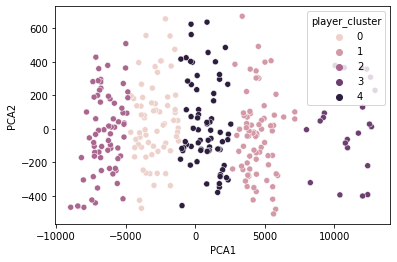

In [30]:
final_table = players_clustering(players_unique)

In [31]:
def merge_changes(first_table,changed_table):
    for i in range(5):
        first_table = pd.merge(first_table,changed_table[['id','map_id','team_id','PCA1','PCA2','player_cluster']].rename(columns={'PCA1':f'p{i+1}_PCA1','PCA2':f'p{i+1}_PCA2','player_cluster':f'p{i+1}_player_cluster'}),how='inner',left_on=[f'p{i+1}_id','map_id','team_id'],right_on=['id','map_id','team_id'])
    first_table = first_table.drop(['id_x','id_y','id'],axis=1)
    for i in range(5):
        col_del = [col for col in first_table.columns if (f'p{i+1}'in col)and(col!=f'p{i+1}_PCA1')and(col!=f'p{i+1}_PCA2')and(col!=f'p{i+1}_player_cluster')and(col!=f'p{i+1}_id')]
        first_table = first_table.drop(col_del,axis=1)
    return first_table

In [32]:
final = merge_changes(stats,final_table)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'id_x'} in the result is deprecated and will raise a MergeError in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


# Merge datasets

In [34]:
df = pd.read_csv('/kaggle/input/csgo-dataset/train.csv')

In [36]:
matches = pd.merge(df,final,left_on=['team1_id','map_id'],right_on=['team_id','map_id'],how='left')

In [38]:
matches = pd.merge(matches,final,left_on=['team2_id','map_id'],right_on=['team_id','map_id'],how='left')

In [39]:
matches = matches.drop(['team_id_y','team_id_x','map_name_x','map_name_y'],axis=1)

In [41]:
useless_cols = [i for i in matches.columns if ('id' in i) or ('name' in i)]

# Models

In [295]:
X = matches.drop(useless_cols,axis=1)

In [297]:
X = X.drop('who_win',axis=1)

In [298]:
y = matches['who_win']

In [299]:
def scaler_feature_generating(X):
    cols_for_scaler = [i for i in X.columns if 'player_cluster' not in i]
    cols_for_keep = [i for i in X.columns if 'player_cluster' in i]
    st = StandardScaler()
    test = st.fit_transform(X[cols_for_scaler])
    final = pd.DataFrame(test,columns=cols_for_scaler)
    final = pd.concat([final,X[cols_for_keep]],axis=1)
    from sklearn.preprocessing import FunctionTransformer
    exponential_transfer = FunctionTransformer(lambda x:x**(3), validate = True)
    exp_df =exponential_transfer.transform(final[cols_for_scaler])
    final = pd.concat([final,pd.DataFrame(exp_df,columns=[i+str('_x3') for i in cols_for_scaler])],axis=1)
    squared_transfer = FunctionTransformer(lambda x:x**(2), validate = True)
    squared_df =squared_transfer.transform(final[cols_for_scaler])
    final = pd.concat([final,pd.DataFrame(squared_df,columns=[i+str('_x2') for i in cols_for_scaler])],axis=1)
    reciprocal_transfer = FunctionTransformer(np.reciprocal, validate = True)
    reciprocal_df = reciprocal_transfer.transform(final[cols_for_scaler])
    final = pd.concat([final,pd.DataFrame(reciprocal_df,columns=[i+str('_reciprocal') for i in cols_for_scaler])],axis=1)
    return final

In [300]:
X = scaler_feature_generating(X)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [302]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

In [303]:
train_dataset = data.TensorDataset(torch.tensor(np.array(X_train)),torch.tensor(np.array(y_train)))
test_dataset = data.TensorDataset(torch.tensor(np.array(X_test)),torch.tensor(np.array(y_test)))


In [304]:
train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
valid_loader = data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2)


In [305]:
def train(model: nn.Module) -> float:
    model.train()

    train_loss = 0

    for x, y in tqdm(train_loader, desc='Train'):
        optimizer.zero_grad()

        output = model(x.float())

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()
        #scheduler.step()

    train_loss /= len(train_loader)
    
    return train_loss

In [306]:
@torch.inference_mode()
def evaluate(model: nn.Module, loader: DataLoader):
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        output = model(x.float())

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [307]:
def plot_stats(
    train_loss,
    valid_loss,
    valid_accuracy,
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(valid_accuracy,label='Valid accuracy')
    plt.grid()

    plt.show()

In [353]:

first_model = nn.Sequential(
    nn.Linear(90, 60),
    nn.LeakyReLU(),
    nn.Dropout2d(p=0.2),
    nn.Linear(60, 30),
    nn.LeakyReLU(),
    nn.Dropout2d(p=0.2),
    nn.Linear(30, 10),
    nn.LeakyReLU(),
    nn.Dropout2d(p=0.2),
    nn.Linear(10, 2),
    nn.Softmax()
)

optimizer = torch.optim.Adam(first_model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()
scheduler =  StepLR(optimizer, 15)

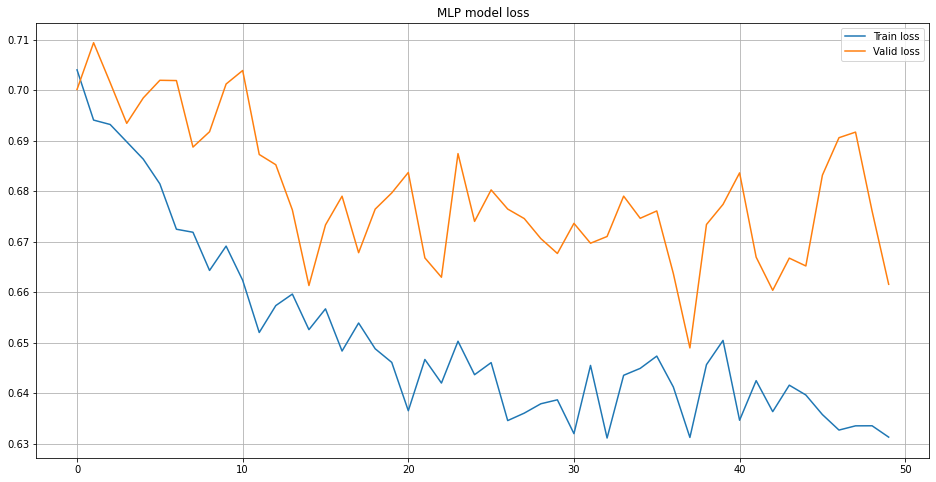

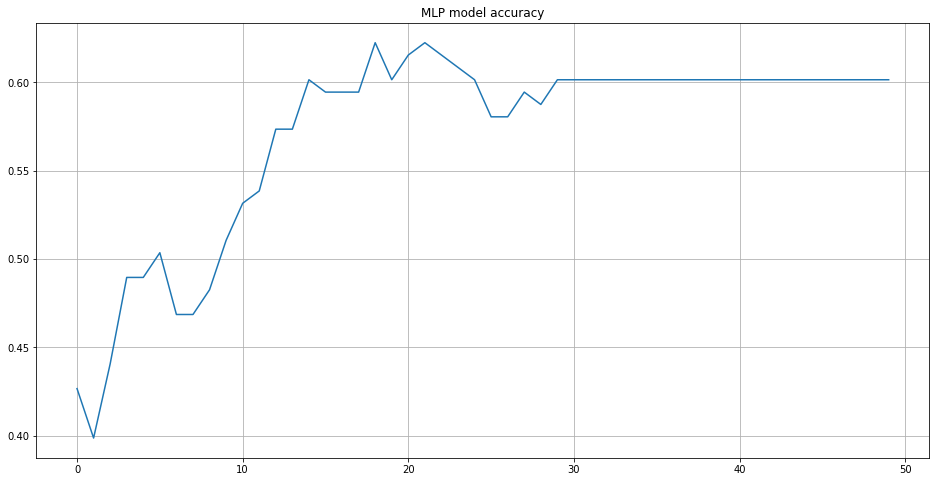

In [354]:
num_epochs = 50

train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

#start = perf_counter()

for epoch in range(num_epochs):
    train_loss = train(first_model)

    valid_loss, valid_accuracy = evaluate(first_model, valid_loader)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)
    scheduler.step()
    clear_output()

    plot_stats(train_loss_history, valid_loss_history, valid_accuracy_history, 'MLP model')
    time.sleep(2)

#print(f'Total training and evaluation time {perf_counter() - start:.5f}')

# Evaluating ROC_AUC

In [398]:
_,pred = torch.max(first_model(torch.tensor(np.array(X_test)).float()),1)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [399]:
roc_auc_score(y_test,pred)

0.6167532986805278

# Predicting

In [384]:
test = pd.read_csv('/kaggle/input/csgo-dataset/test.csv',index_col=0)

In [385]:
matches = pd.merge(test,final,left_on=['team1_id','map_id'],right_on=['team_id','map_id'],how='left')

In [386]:
matches = pd.merge(matches,final,left_on=['team2_id','map_id'],right_on=['team_id','map_id'],how='left')

In [387]:
matches = matches.drop(['team_id_y','team_id_x','map_name_x','map_name_y'],axis=1)

In [389]:
useless_cols = [i for i in matches.columns if ('id' in i) or ('name' in i)]

In [388]:
X = matches.drop(useless_cols,axis=1)

In [ ]:
X = X.drop('who_win',axis=1)

In [ ]:
y = matches['who_win']

In [390]:
X = scaler_feature_generating(X)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [392]:
_,pred = torch.max(first_model(torch.tensor(np.array(X)).float()),1)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [394]:
torch.save(pred,'predictions_finals.pt')